In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from tensorflow.contrib.layers import conv2d, fully_connected

In [2]:
image_size = 224
batch_size = 2


In [3]:
session = tf.Session()

In [4]:
import tensorflow as tf
from tensorflow.contrib.layers import conv2d, fully_connected, max_pool2d, repeat

slim = tf.contrib.slim

# Network definition copied from https://github.com/tensorflow/models/blob/master/slim/nets/vgg.py
def vgg_16(inputs, num_classes=1000, scope='vgg_16'):
    
    with tf.variable_scope(scope, 'vgg_16', [inputs]) as sc:
        
        with slim.arg_scope([conv2d, fully_connected, max_pool2d]):
            net = repeat(inputs, 2, slim.conv2d, 64, [3, 3], scope='conv1')
            net = max_pool2d(net, [2, 2], scope='pool1')
            net = repeat(net, 2, slim.conv2d, 128, [3, 3], scope='conv2')
            net = max_pool2d(net, [2, 2], scope='pool2')
            net = repeat(net, 3, slim.conv2d, 256, [3, 3], scope='conv3')
            net = max_pool2d(net, [2, 2], scope='pool3')
            net = repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv4')
            net = max_pool2d(net, [2, 2], scope='pool4')
            net = repeat(net, 3, slim.conv2d, 512, [3, 3], scope='conv5')
            net = max_pool2d(net, [2, 2], scope='pool5')
            # Use conv2d instead of fully_connected layers.
            net = conv2d(net, 4096, [7, 7], padding='VALID', scope='fc6')
            net = conv2d(net, 4096, [1, 1], scope='fc7')
            net = conv2d(net, num_classes, [1, 1], activation_fn=None, normalizer_fn=None, scope='fc8')
            
            return net    

In [5]:
inputs = tf.placeholder(tf.float32, [batch_size, 224, 224, 3])

logits=vgg_16(inputs, 1000)

probabilities=tf.contrib.layers.softmax(logits)

In [6]:
images=[]

filename="images/sax.jpg"

image1=mpimg.imread(filename)

image1= tf.image.resize_images(image1, [224, 224], method=0, 
                                           align_corners=False)
image1 = tf.squeeze(image1)

image1 = image1.eval(session=session)

filename="images/people.jpg"

image2=mpimg.imread(filename)

image2= tf.image.resize_images(image2, [224, 224], method=0, 
                                           align_corners=False)
image2 = tf.squeeze(image2)

image2 = image2.eval(session=session)

images = np.stack((image1, image2))
#print(images.shape)




In [7]:
init = tf.global_variables_initializer()

session.run(init)

checkpoint_path ="vgg_16.ckpt" 

variables_to_restore = slim.get_variables(scope="vgg_16")

restorer = tf.train.Saver(variables_to_restore)

restorer.restore(session, checkpoint_path)


INFO:tensorflow:Restoring parameters from vgg_16.ckpt


In [8]:
def calc_probs(processed_images):

       
    probs = session.run(probabilities, feed_dict={inputs:processed_images})
    probs=np.reshape(probs, (batch_size, -1))
    #print(probs)
    t=-probs
    sorted_inds=np.argsort(t, axis=1)
#     print(sorted_inds)
#     print(probs.shape)
    max_class_index=sorted_inds[:,0]
#     print(max_class_index)
#     print(probs[0][max_class_index[0]])
    return probs, max_class_index

In [9]:

probs, actual_class_index = calc_probs(images)
actual_probability=[]
#print(actual_probability.shape)
for i in range(probs.shape[0]):
    actual_probability.append(probs[i][actual_class_index[i]])
#print(actual_probability)
#print(actual_class_index)

Region:  0 0
probabilities:  [0.9942683, 0.69532955] [0.99642366, 0.62473369]
Region:  0 50
probabilities:  [0.9942683, 0.69532955] [0.99545938, 0.13306028]
Region:  0 100
probabilities:  [0.9942683, 0.69532955] [0.9921639, 0.45620394]
Region:  0 150
probabilities:  [0.9942683, 0.69532955] [0.99477959, 0.069570623]
Region:  0 200
probabilities:  [0.9942683, 0.69532955] [0.99590611, 0.58862084]
Region:  50 0
probabilities:  [0.9942683, 0.69532955] [0.99444383, 0.68224293]
Region:  50 50
probabilities:  [0.9942683, 0.69532955] [0.99023902, 0.85021299]
Region:  50 100
probabilities:  [0.9942683, 0.69532955] [0.6834324, 0.49414015]
Region:  50 150
probabilities:  [0.9942683, 0.69532955] [0.90002412, 0.40895844]
Region:  50 200
probabilities:  [0.9942683, 0.69532955] [0.99567103, 0.69695127]
Region:  100 0
probabilities:  [0.9942683, 0.69532955] [0.99378443, 0.88881588]
Region:  100 50
probabilities:  [0.9942683, 0.69532955] [0.9980123, 0.92223287]
Region:  100 100
probabilities:  [0.994268

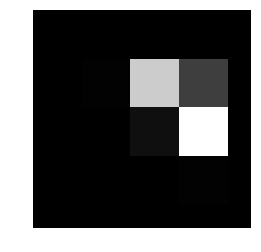

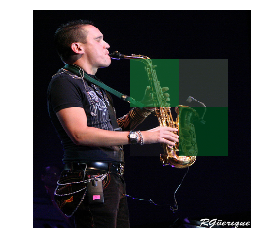

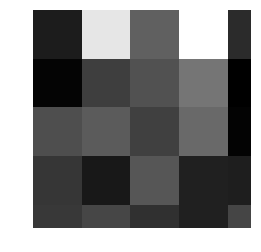

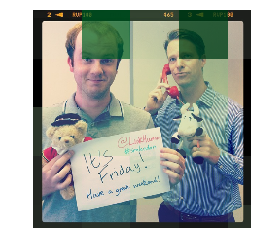

In [10]:

image_height=image_size
image_width=image_size

occ_height=50
occ_width=50

occlusion=np.ndarray(shape=(occ_height,occ_width))
heatmap=np.zeros((batch_size, image_height, image_width),dtype=np.uint8)
 
    
ite_height=image_height-occ_height
ite_width=image_width-occ_width


for i in range(0, image_height, occ_height):
    for j in range(0, image_width, occ_width):
        print("Region: ", i, j)
        im_occ=np.array(images, copy=True)
        
        #im_occ=((im_occ)).eval(session=session)
        occ_height_end=min(image_height,i+occ_height)
        occ_width_end=min(image_width,j+occ_width)

        #print(occ_height_end)
        #print(occ_width_end)

        im_occ[:,i:occ_height_end,j:occ_width_end,:]=255
        #print(im_occ.shape)
        #plt.imshow(im_occ[0].astype(np.uint8))
        #plt.show()   
        
        probs, _ = calc_probs(im_occ)
        pred_probability=[]
        for b in range(probs.shape[0]):
            pred_probability.append(probs[b][actual_class_index[b]])
        print("probabilities: ", actual_probability, pred_probability)
        
        
        for k in range(images.shape[0]):    
            heatmap[k, i:occ_height_end,j:occ_width_end] = (abs(actual_probability[k]-pred_probability[k]))*255
            
        
cmap_overlay = plt.cm.Greens
cmap_overlay._init()
cmap_overlay._lut[:,-1] = np.linspace(0, 0.8, 259)

for l in range(batch_size):
    
    plt.imshow(heatmap[l].astype(np.uint8), cmap='gray')
    plt.axis('off')
    plt.show() 
    
    plt.imshow(images[l].astype(np.uint8))
    plt.imshow(heatmap[l].astype(np.uint8), cmap = cmap_overlay)
    plt.axis('off')
    plt.show()
        